In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
# %matplotlib qt5
%matplotlib inline

In [347]:
data_test = pd.read_csv('./cs-test.csv',index_col=0)

In [348]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101503 entries, 1 to 101503
Data columns (total 11 columns):
SeriousDlqin2yrs                        0 non-null float64
RevolvingUtilizationOfUnsecuredLines    101503 non-null float64
age                                     101503 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    101503 non-null int64
DebtRatio                               101503 non-null float64
MonthlyIncome                           81400 non-null float64
NumberOfOpenCreditLinesAndLoans         101503 non-null int64
NumberOfTimes90DaysLate                 101503 non-null int64
NumberRealEstateLoansOrLines            101503 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    101503 non-null int64
NumberOfDependents                      98877 non-null float64
dtypes: float64(5), int64(6)
memory usage: 9.3 MB


In [210]:
data_train = pd.read_csv('./cs-training.csv',index_col=0)

In [211]:
data_train.columns.sort_values()

Index(['DebtRatio', 'MonthlyIncome', 'NumberOfDependents',
       'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTime30-59DaysPastDueNotWorse',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'RevolvingUtilizationOfUnsecuredLines',
       'SeriousDlqin2yrs', 'age'],
      dtype='object')

In [212]:
col_replace = {'SeriousDlqin2yrs':'target', ## 违约客户及超过90天逾期客户，bool型；
            'RevolvingUtilizationOfUnsecuredLines':'percentage', ## 贷款以及信用卡可用额度与总额度比例，百分比；
           'NumberOfOpenCreditLinesAndLoans':'open_loan', ## 开放式信贷和贷款数量，开放式贷款（分期付款如汽车贷款或抵押贷款）和信贷（如信用卡）的数量，整型；
           'NumberOfTimes90DaysLate':'90-', ## 90天逾期次数：借款者有90天或更高逾期的次数，整型；
           'NumberRealEstateLoansOrLines':'estate_loan', ## 不动产贷款或额度数量：抵押贷款和不动产放款包括房屋净值信贷额度，整型；
           'NumberOfTime60-89DaysPastDueNotWorse':'60-89', ## 60-89天逾期但不糟糕次数，整型；
           'NumberOfDependents':'Dependents', ## 家属数量：不包括本人在内的家属数量，整型；
           'NumberOfTime30-59DaysPastDueNotWorse':'30-59' ## 35-59天逾期但不糟糕次数，整型；
              }
data_train.rename(columns=col_replace,inplace=True)

In [213]:
data_train.head()

,target,percentage,age,30-59,DebtRatio,MonthlyIncome,open_loan,90-,estate_loan,60-89,Dependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [214]:
data_train.info() ## 说明只有两项有缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
target           150000 non-null int64
percentage       150000 non-null float64
age              150000 non-null int64
30-59            150000 non-null int64
DebtRatio        150000 non-null float64
MonthlyIncome    120269 non-null float64
open_loan        150000 non-null int64
90-              150000 non-null int64
estate_loan      150000 non-null int64
60-89            150000 non-null int64
Dependents       146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


## 重复值

In [215]:
data_train.duplicated().sum()

609

In [216]:
data_train.drop_duplicates(inplace=True)

## 缺失值

In [217]:
data_train.loc[data_train.MonthlyIncome.isna(),'Dependents'].isna().mean()

0.13100167687621916

In [218]:
data_train.loc[data_train.Dependents.isna(),'MonthlyIncome'].isna().mean() ## 结果1，说明家属没填的，月收入都没填。

1.0

In [219]:
data_train.dropna(subset=['Dependents'],inplace=True) ## 去掉两项都缺的项。

In [220]:
data_train.isna().mean() ## 需要填充月收入

target           0.000000
percentage       0.000000
age              0.000000
30-59            0.000000
DebtRatio        0.000000
MonthlyIncome    0.174447
open_loan        0.000000
90-              0.000000
estate_loan      0.000000
60-89            0.000000
Dependents       0.000000
dtype: float64

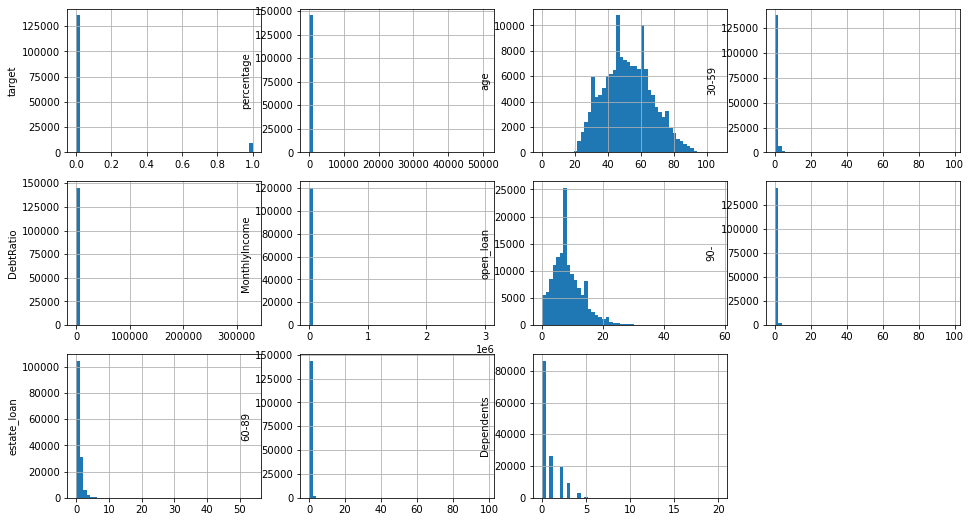

In [221]:
## 考察其他项有什么特征
plt.figure(figsize=(16,9))
for i,col in enumerate(data_train.columns):
    plt.subplot(3,4,i+1)
    data_train[col].hist(bins=50)
    plt.ylabel(col)
## 看出DebtRatio有大量0值，支出比例为0，违背常识视为异常值

In [17]:
# data_train.query('DebtRatio>0',inplace=True)

In [223]:
data_train_bak = data_train.copy()

In [224]:
## 填充缺失值
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import KNNImputer
miss_imputer = IterativeImputer(ExtraTreesRegressor(10),initial_strategy="most_frequent")
# miss_imputer2 = KNNImputer()
data_train_bak.iloc[:,:-1]=miss_imputer.fit_transform(X=data_train.iloc[:,:-1])


(array([ 7830., 19028., 24132., 21627., 14975., 11265.,  7993.,  4405.,
         2623.,  1762.]),
 array([    0. ,  1599.9,  3199.8,  4799.7,  6399.6,  7999.5,  9599.4,
        11199.3, 12799.2, 14399.1, 15999. ]),
 <a list of 10 Patch objects>)

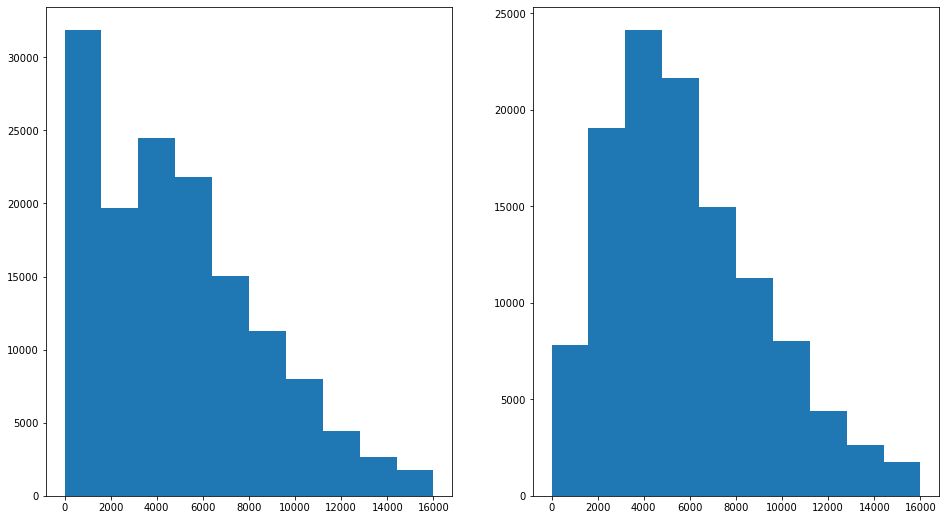

In [225]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.hist(data_train_bak.loc[data_train_bak.MonthlyIncome<16000,'MonthlyIncome'])
plt.subplot(122)
plt.hist(data_train.loc[data_train.MonthlyIncome<16000,'MonthlyIncome'])
## 填充结果改变了数据分布，不采用。

In [226]:
## 改用随机抽样填充
# from scipy.stats import norm
# mean,std = norm.fit(data_train.MonthlyIncome[data_train.MonthlyIncome.notna()])
fill_len = data_train.MonthlyIncome.isna().sum()
data_train.loc[data_train.MonthlyIncome.isna(),'MonthlyIncome']=\
np.random.choice(data_train.loc[data_train.MonthlyIncome.notna(),'MonthlyIncome'],fill_len,False)

In [227]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145563 entries, 1 to 150000
Data columns (total 11 columns):
target           145563 non-null int64
percentage       145563 non-null float64
age              145563 non-null int64
30-59            145563 non-null int64
DebtRatio        145563 non-null float64
MonthlyIncome    145563 non-null float64
open_loan        145563 non-null int64
90-              145563 non-null int64
estate_loan      145563 non-null int64
60-89            145563 non-null int64
Dependents       145563 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.3 MB


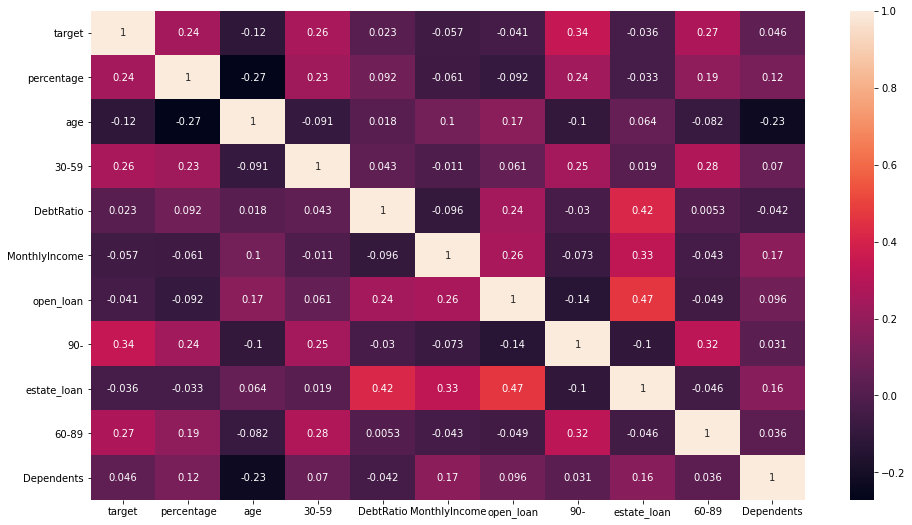

In [228]:
plt.figure(figsize=(16,9))
sns.heatmap(data_train.corr(method='spearman'),annot=True)
## 无>0.5的相关性, 暂不考虑降维

In [229]:
## 特征工程前，重置索引
data_train.reset_index(drop=True, inplace=True)

## 自定分箱 卡方分箱 spearman分箱

In [230]:
import scipy

In [231]:
def init_box(df,n_split):
    ## 待份变量等频初始化分箱，统计分箱后标签频数
    categ = pd.cut(df.iloc[:,0],n_split,duplicates='raise')
    freq = pd.crosstab(categ, df.iloc[:,1]).reset_index()
    freq.iloc[:,0] = freq.iloc[:,0].astype(object)

    ## 计算WOE,IV
    freq['woe'] = np.log(freq[1]/freq[0]*freq[0].sum()/freq[1].sum())
    iv = freq.woe.dot((freq[1]/freq[1].sum()-freq[0]/freq[0].sum()))
    
    return freq.set_index(freq.columns[0]), iv ## reindex方便后续计算

In [232]:
def mychi2(freq):
    R = freq.sum(1,keepdims=True)
    C = freq.sum(0)
    N = R.sum()
    E = R*C / N
    sqr = np.square(freq-E)/E
    sqr[E==0] = 0
    return sqr.sum()

In [233]:
chi2 = lambda x: scipy.stats.chi2_contingency(x,correction=False)[1]
add = lambda in1,in2: pd.Interval(in1.left,in2.right)
def chi2_box(df, n_split=20, p_thr=.05):
    '''
    df:两列，第一列是待分箱变量，第二列是标签
    n_split: 初始划分区间数
    p_thr: 拒绝概率
    '''
    ## 待份变量等频初始化分箱，统计分箱后标签频数
    categ = pd.qcut(df.iloc[:,0],n_split,duplicates='drop')
    freq = pd.crosstab(categ, df.iloc[:,1]).reset_index()
    freq.iloc[:,0] = freq.iloc[:,0].astype(object)
    
    ## 相邻箱计算p值
    while True:
        p_val = [chi2(freq.iloc[i:i+2,1:]) for i in range(len(freq))]
        p_max = np.argmax(p_val[:-1])
        if p_val[p_max] <= p_thr:
            break
        freq.iloc[p_max,0] = add(freq.iloc[p_max,0], freq.iloc[p_max+1,0])
        freq.iloc[p_max,1:] = freq.iloc[p_max,1:] + freq.iloc[p_max+1,1:]
        freq.drop(index=freq.index[p_max+1],inplace=True)
    freq.iloc[-1,0] = add(freq.iloc[-1,0], pd.Interval(0,np.inf)) ## 适配数据
    freq.iloc[0,0] = add(pd.Interval(-np.inf,0), freq.iloc[0,0]) ## 适配数据

    ## 计算WOE,IV
    freq['p_val'] = p_val
    freq['woe'] = np.log(freq[1]/freq[0]*freq[0].sum()/freq[1].sum())
    iv = freq.woe.dot((freq[1]/freq[1].sum()-freq[0]/freq[0].sum()))
    
    return freq.set_index(freq.columns[0]),iv
    

(y                0     1          p_val       woe
 age                                              
 (-inf, 9.0]   8957  1043  3.986888e-262 -1.744348
 (9.75, 29.0]  6991  3009  3.155419e-176 -0.437030
 (29.5, 44.0]  5031  4969  1.007542e-183  0.393586
 (44.25, inf]  3026  6974   1.000000e+00  1.240933,
 1.0066018916777513)

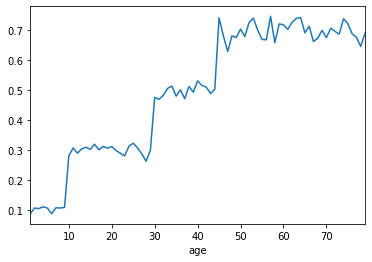

In [234]:
## test function 

num = 10000  ##构造一个有40000数据量的数据
x1 = np.random.randint(1,10,num)
x2 = np.random.randint(10,30,num)
x3 = np.random.randint(30,45,num)
x4 = np.random.randint(45,80,num)
x = np.r_[x1,x2,x3,x4]

y1 = np.random.choice([0,1],num,p=[.9,.1])
y2 = np.random.choice([0,1],num,p=[.7,.3])
y3 = np.random.choice([0,1],num,p=[.5,.5])
y4 = np.random.choice([0,1],num,p=[.3,.7])
y = np.r_[y1,y2,y3,y4]

testdata = pd.DataFrame({"age":x,"y":y})
testdata.groupby('age')['y'].mean().plot()
chi2_box(testdata,100,.001)

In [235]:
spearman = lambda x: scipy.stats.spearmanr(x.iloc[:,0], x.iloc[:,1])[0]
def spearman_box(df, n = 20, r_thr=1):
    r = 0
    while np.abs(r) < r_thr:
        categ = pd.qcut(df.iloc[:,0], n, duplicates='drop')
        d2 = df.groupby(categ).mean()
        r = spearman(d2)
        n = n - 1
    freq = pd.crosstab(categ, df.iloc[:,1]).reset_index()
    freq['woe'] = np.log(freq[1]/freq[0]*freq[0].sum()/freq[1].sum())
    iv = freq.woe.dot((freq[1]/freq[1].sum()-freq[0]/freq[0].sum()))
    return freq.set_index(freq.columns[0]),iv

target,0,1,p_val,woe
age,,,,
"(-inf, 35.0]",18407,2324,9.147726e-13,0.555701
"(35.0, 43.0]",20674,2080,1.635015e-08,0.328633
"(43.0, 53.0]",33116,2809,3.981809e-10,0.157954
"(53.0, 57.0]",12765,840,1.233567e-07,-0.095919
"(57.0, 62.0]",15820,796,5.346722e-10,-0.364289
"(62.0, 67.0]",13401,467,4.955616e-09,-0.731614
"(67.0, inf]",21549,515,1.000000e+00,-1.108776


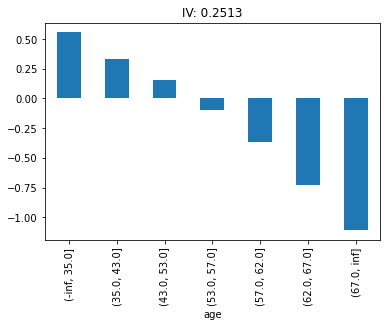

In [236]:
age_box,age_iv = chi2_box(data_train[['age','target']],50,.001)
display(age_box,age_box.woe.plot(kind='bar',title=f'IV: {age_iv:.4f}'))

target,0,1,p_val,woe
MonthlyIncome,,,,
"(-inf, 1300.0]",6883,481,3.281411e-13,-0.035801
"(1300.0, 3400.0]",26509,2687,3.106866e-15,0.336083
"(3400.0, 5400.0]",33621,2725,1.224283e-10,0.112459
"(5400.0, 7500.0]",27524,1824,3.668532e-07,-0.088885
"(7500.0, 10100.0]",20419,1109,9.467533e-03,-0.287865
"(10100.0, inf]",20776,1005,1.000000e+00,-0.403669


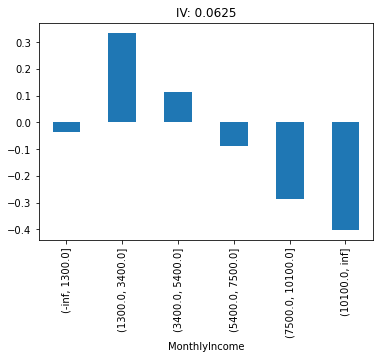

In [237]:
MI_box,MI_iv = chi2_box(data_train[['MonthlyIncome','target']],20,.01)
display(MI_box,MI_box.woe.plot(kind='bar',title=f'IV: {MI_iv:.4f}'))

target,0,1,p_val,woe
percentage,,,,
"(-inf, 0.00345]",14178,379,1.249396e-18,-0.996769
"(0.00345, 0.0627]",35859,531,2.496180e-07,-1.587446
"(0.0627, 0.118]",14250,306,8.000203e-07,-1.215785
"(0.118, 0.211]",14118,439,8.127718e-04,-0.845565
"(0.211, 0.277]",6996,282,4.473996e-03,-0.586045
"(0.277, 0.355]",6926,352,5.154532e-03,-0.354265
"(0.355, 0.449]",6850,428,1.026761e-05,-0.147739
"(0.449, 0.561]",6716,562,2.922821e-06,0.144396
"(0.561, 0.698]",6556,722,3.955819e-14,0.419031


1.1516485848994455

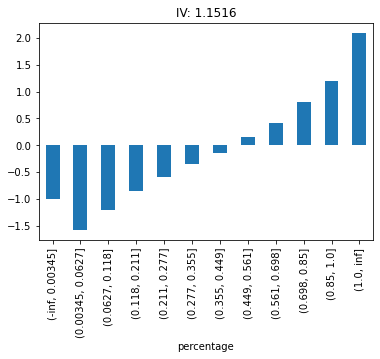

In [238]:
per_box,per_iv = chi2_box(data_train[['percentage','target']],20,.01)
display(per_box,per_iv,per_box.woe.plot(kind='bar',title=f'IV: {per_iv:.4f}'))

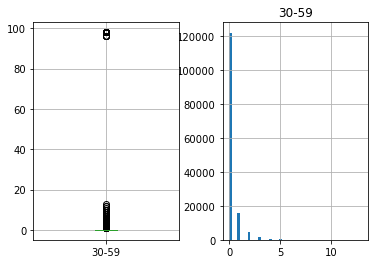

In [239]:
ax1 = plt.subplot(122)
data_train.loc[data_train['30-59'].lt(20),['30-59']].hist(ax=ax1,bins=50)
ax2=plt.subplot(121)
data_train[['30-59']].boxplot(ax=ax2)

target,0,1,p_val,woe
30-59,,,,
"(-inf, 1.0]",130459,7306,0.000000e+00,-0.257221
"(1.0, 2.0]",3336,1202,2.513147e-39,1.604356
"(2.0, inf]",1937,1323,1.000000e+00,2.243903


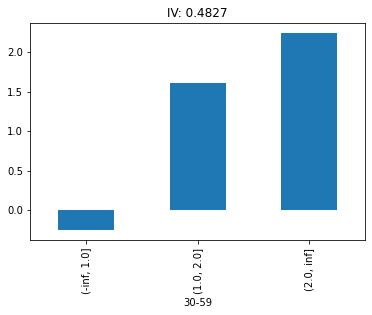

In [240]:
n30_box,n30_iv = chi2_box(data_train[['30-59','target']],20,.05)
display(n30_box,n30_box.woe.plot(kind='bar',title=f'IV: {n30_iv:.4f}')) ## 每箱数量差别太大，改手动分箱。

target,0,1,woe
30-59,,,
"(-inf, 0.1]",117077,4943,-0.539718
"(0.1, 1.1]",13382,2363,0.891163
"(1.1, 2.1]",3336,1202,1.604356
"(2.1, 3.1]",1131,610,2.007743
"(3.1, 4.1]",419,316,2.343013
"(4.1, inf]",387,397,2.650653


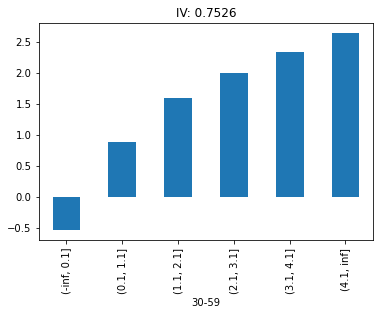

In [241]:
split = [-np.inf,.1,*np.arange(1.1,5,1),np.inf]
n30_box,n30_iv = init_box(data_train[['30-59','target']],split)
display(n30_box,n30_box.woe.plot(kind='bar',title=f'IV: {n30_iv:.4f}')) ## 每箱数量差别太大，改手动分箱。

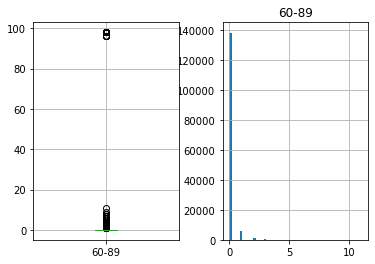

In [242]:
ax1 = plt.subplot(122)
data_train.loc[data_train['60-89'].lt(20),['60-89']].hist(ax=ax1,bins=50)
ax2=plt.subplot(121)
data_train[['60-89']].boxplot(ax=ax2)

target,0,1,p_val,woe
60-89,,,,
"(-inf, 1.0]",134899,8876,0.0,-0.096034
"(1.0, inf]",833,955,1.0,2.761819


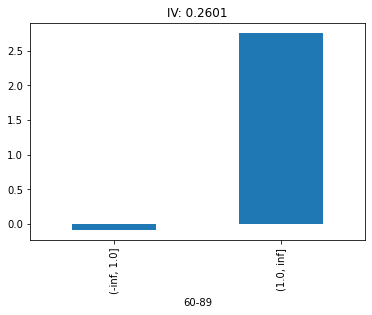

In [243]:
n60_box,n60_iv = chi2_box(data_train[['60-89','target']],20,.05)
display(n60_box,n60_box.woe.plot(kind='bar',title=f'IV: {n60_iv:.4f}')) ## 每箱数量差别太大，改手动分箱。

target,0,1,woe
60-89,,,
"(-inf, 0.1]",130994,7134,-0.285138
"(0.1, 1.1]",3905,1742,1.817918
"(1.1, 2.1]",552,551,2.623328
"(2.1, 3.1]",136,176,2.882971
"(3.1, 4.1]",40,65,3.110650
"(4.1, inf]",105,163,3.064932


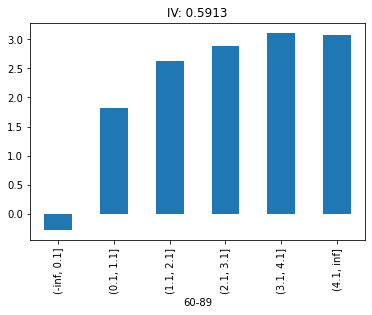

In [244]:
split = [-np.inf,.1,*np.arange(1.1,5,1),np.inf]
n60_box,n60_iv = init_box(data_train[['60-89','target']],split)
display(n60_box,n60_box.woe.plot(kind='bar',title=f'IV: {n60_iv:.4f}')) ## 每箱数量差别太大，改手动分箱。

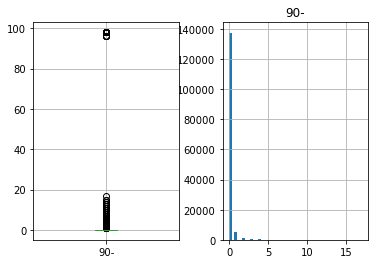

In [245]:
ax1 = plt.subplot(122)
data_train.loc[data_train['90-'].lt(20),['90-']].hist(ax=ax1,bins=50)
ax2=plt.subplot(121)
data_train[['90-']].boxplot(ax=ax2)

target,0,1,p_val,woe
90-,,,,
"(-inf, 1.0]",131865,8091,0.0,-0.173739
"(1.0, inf]",1312,1631,1.0,2.834928


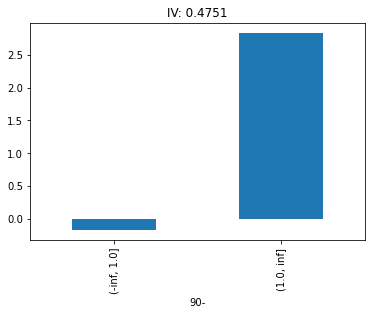

In [246]:
n90_box,n90_iv = chi2_box(data_train.loc[data_train.MonthlyIncome>1,['90-','target']],20,.05)
display(n90_box,n90_box.woe.plot(kind='bar',title=f'IV: {n90_iv:.4f}')) ## 每箱数量差别太大，改手动分箱。

target,0,1,woe
90-,,,
"(-inf, 0.1]",131009,6441,-0.387441
"(0.1, 1.1]",3396,1734,1.952974
"(1.1, 2.1]",762,760,2.622514
"(2.1, 3.1]",279,377,2.926175
"(3.1, inf]",286,519,3.221054


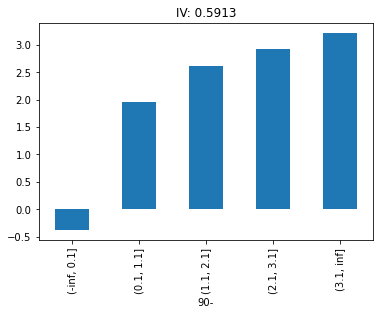

In [247]:
split = [-np.inf,.1,*np.arange(1.1,4,1),np.inf]
n90_box,n90_iv = init_box(data_train[['90-','target']],split)
display(n90_box,n90_box.woe.plot(kind='bar',title=f'IV: {n60_iv:.4f}')) ## 每箱数量差别太大，改手动分箱。

target,0,1,p_val,woe
DebtRatio,,,,
"(-inf, 0.00323]",5449,374,1.258304e-08,-0.053790
"(0.00323, 0.017]",5585,237,3.280947e-12,-0.534638
"(0.017, 0.226]",32689,2246,1.717865e-08,-0.052746
"(0.226, 0.343]",22056,1234,3.229789e-10,-0.258182
"(0.343, 0.504]",21734,1556,4.151254e-16,-0.011618
"(0.504, 0.662]",10584,1061,6.343653e-09,0.325010
"(0.662, 1.365]",10315,1330,7.075795e-22,0.576721
"(1.365, 688.0]",10752,899,1.741907e-19,0.143578
"(688.0, inf]",16568,894,1.000000e+00,-0.294381


0.07429044349834137

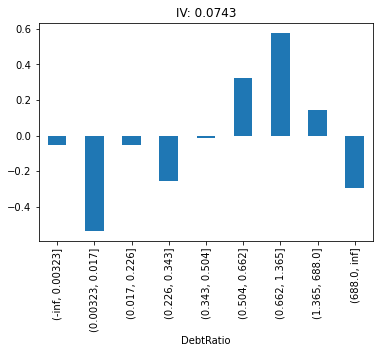

In [248]:
debt_box,debt_iv = chi2_box(data_train.loc[:,['DebtRatio','target']],25,.001)
display(debt_box,debt_iv)
debt_box.woe.plot(kind='bar',title=f'IV: {debt_iv:.4f}') ## 效果差，用手动分箱

D:\Program Files\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
D:\Program Files\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
D:\Program Files\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
D:\Program Files\Anaconda3\lib\site-packages\pandas\plottin

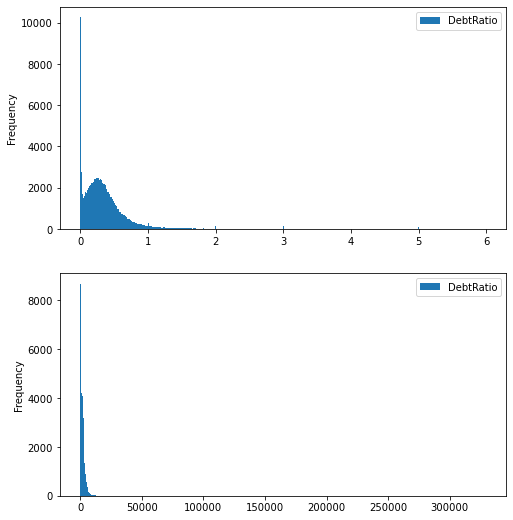

In [249]:
ax1 = plt.subplot(211)
data_train.query('6>DebtRatio')[['DebtRatio']].plot(kind='hist',ax=ax1, bins=500,figsize=(8,9))
## 0.04之前有异常，单独分一个箱
ax2 = plt.subplot(212)
data_train.query('6<=DebtRatio')[['DebtRatio']].plot(kind='hist',ax=ax2, bins=500,figsize=(8,9))
## 后面是一个长尾分布

target,0,1,woe
DebtRatio,,,
"(-inf, 0.08]",19377,1244,-0.120613
"(0.08, 0.2]",19445,1312,-0.070896
"(0.2, 0.3]",19183,1089,-0.243623
"(0.3, 0.4]",16945,1067,-0.139980
"(0.4, 0.5]",12221,914,0.032061
"(0.5, 0.6]",7645,742,0.292684
"(0.6, 0.7]",4905,519,0.379035
"(0.7, 0.8]",3024,374,0.535062
"(0.8, 0.9]",1953,246,0.553351


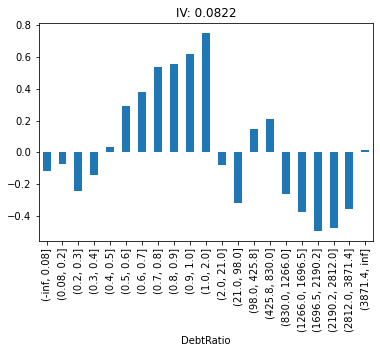

In [277]:
split = [-np.inf,.08,*np.arange(.2,1.1,.1),]
split2 = data_train.DebtRatio[data_train.DebtRatio.gt(2)].quantile(np.arange(10)/10).tolist()
b=split+split2+[np.inf]
debt_box,debt_iv = init_box(data_train.loc[:,['DebtRatio','target']],b)
# debt_box,debt_iv = init_box(data_train.loc[:,['DebtRatio','target']],b)
# debt_box,debt_iv = spearman_box(data_train.loc[:,['DebtRatio','target']],r_thr=.5)
display(debt_box)
debt_box.woe.plot(kind='bar',title=f'IV: {debt_iv:.4f}')

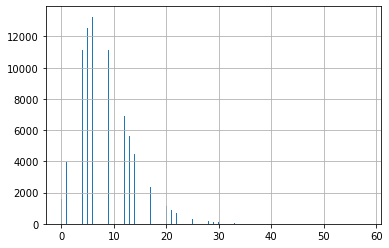

In [256]:
data_train.open_loan.hist(bins=500)

target,0,1,p_val,woe
open_loan,,,,
"(-inf, 2.0]",10098,1594,2.219557e-38,0.779051
"(2.0, 3.0]",7853,666,4.829875e-05,0.157780
"(3.0, 5.0]",22082,1540,2.792500e-05,-0.037839
"(5.0, 7.0]",24722,1473,3.244686e-03,-0.195251
"(7.0, 8.0]",11711,603,3.758710e-05,-0.341225
"(8.0, 13.0]",38973,2432,4.598320e-08,-0.149013
"(13.0, inf]",20293,1523,1.000000e+00,0.035548


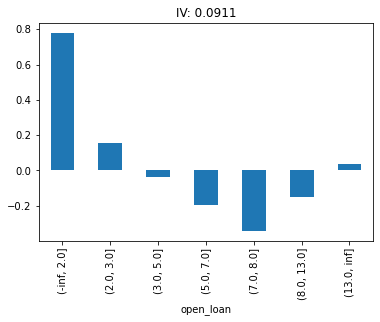

In [258]:
# loan_box,loan_iv = init_box(data_train.loc[:,['open_loan','target']],np.arange(15))
# loan_box,loan_iv = spearman_box(data_train.loc[:,['open_loan','target']],r_thr=.1)
loan_box,loan_iv = chi2_box(data_train.loc[:,['open_loan','target']])
display(loan_box)
loan_box.woe.plot(kind='bar',title=f'IV: {loan_iv:.4f}')

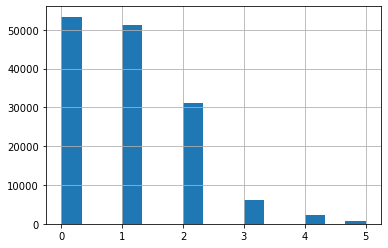

In [259]:
data_train.query('estate_loan<6').estate_loan.hist(bins=15)

target,0,1,woe
estate_loan,,,
"(-inf, 0.0]",48840,4540,0.249519
"(0.0, 1.0]",48477,2714,-0.257524
"(1.0, 2.0]",29411,1745,-0.199473
"(2.0, 3.0]",5812,418,-0.007057
"(3.0, 5.0]",2545,274,0.396384
"(5.0, inf]",647,140,1.094438


0.06812956409186506

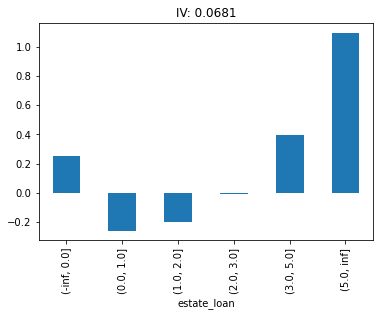

In [264]:
estate_box,estate_iv = init_box(data_train[['estate_loan','target']],
                               n_split = [-np.inf, 0, 1, 2, 3, 5, np.inf])
# estate_box,estate_iv = spearman_box(data_train[['estate_loan','target']],r_thr=.05)
display(estate_box,estate_iv)
estate_box.woe.plot(kind='bar',title=f'IV: {estate_iv:.4f}')

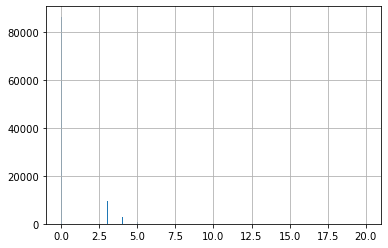

In [265]:
data_train.Dependents.hist(bins=500)

target,0,1,woe
Dependents,,,
"(-inf, 0.0]",81313,5079,-0.148050
"(0.0, 1.0]",24379,1935,0.091527
"(1.0, 2.0]",17937,1584,0.198229
"(2.0, 3.0]",8646,837,0.290114
"(3.0, 5.0]",3243,365,0.440785
"(5.0, inf]",214,31,0.693153


0.03267055012571012

Text(0.5, 0, 'Dependents')

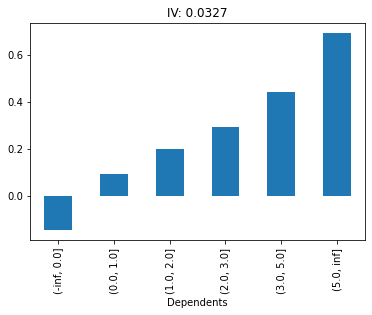

In [266]:
depend_box,depend_iv = init_box(data_train[['Dependents','target']],
                               n_split = [-np.inf, 0, 1, 2, 3, 5, np.inf])
# depend_box,depend_iv = chi2_box(data_train[['Dependents','target']])
display(depend_box,depend_iv)
plt.figure()
depend_box.woe.plot(kind='bar',title=f'IV: {depend_iv:.4f}')
plt.xlabel('Dependents')

## WOE替换

In [300]:
data_train.dtypes

target             int64
percentage       float64
age              float64
30-59            float64
DebtRatio        float64
MonthlyIncome    float64
open_loan        float64
90-              float64
estate_loan      float64
60-89            float64
Dependents       float64
dtype: object

In [322]:
woe_map = { 'percentage':per_box,
            'age':age_box,
            '30-59':n30_box,
            'DebtRatio':debt_box,
            'MonthlyIncome':MI_box,
            'open_loan':loan_box,
            '90-':n90_box,
            'estate_loan':estate_box,
            '60-89':n60_box,
            'Dependents':depend_box}
def woe_swag(df,woe=woe_map):
    df2={k:v.loc[df[k],'woe'].reset_index(drop=True) for k,v in woe.items()}
    df2['target'] = df.target
    return pd.DataFrame(df2)

In [307]:
## 替换变量
# data_train_bak = data_train.copy()
# data_train = data_train_bak.copy()

In [308]:
data_train = woe_swag(data_train)

In [309]:
data_train.head()

,percentage,age,30-59,DebtRatio,MonthlyIncome,open_loan,90-,estate_loan,60-89,Dependents
0,0.808801,0.157954,1.604356,0.553351,-0.287865,-0.149013,-0.387441,1.094438,-0.285138,0.198229
1,1.198760,0.328633,-0.539718,-0.070896,0.336083,-0.037839,-0.387441,0.249519,-0.285138,0.091527
2,0.419031,0.328633,0.891163,-0.070896,0.336083,0.779051,1.952974,0.249519,-0.285138,-0.148050
3,-0.586045,0.555701,-0.539718,-0.120613,0.336083,-0.037839,-0.387441,0.249519,-0.285138,-0.148050
4,1.198760,0.157954,0.891163,-0.120613,-0.403669,-0.195251,-0.387441,-0.257524,-0.285138,-0.148050


In [290]:
## 将正负样本SMOTE
X, y = data_train.iloc[:,:-1].values, data_train.iloc[:,-1:].values
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=.5,n_jobs=-1)
X_res, y_res = smote.fit_resample(X, y)

## 模型训练

In [293]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

In [295]:
ss = StandardScaler()
X_res = ss.fit_transform(X_res)
# X_test = ss.transform(X_test)

In [313]:
lr = LogisticRegression()
lr.fit(X_res,y_res)

LogisticRegression()

## 模型评估

In [333]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [340]:
y_pred = lr.predict_proba(X_res);y_pred[:,1]

array([0.82905978, 0.43580942, 0.81355667, ..., 0.23053305, 0.90821262,
       0.60206122])

In [339]:
y_res

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [342]:
fpr, tpr, thre = roc_curve(y_res, y_pred[:,1])
roc_auc = auc(fpr,tpr); roc_auc

0.8588842723515008

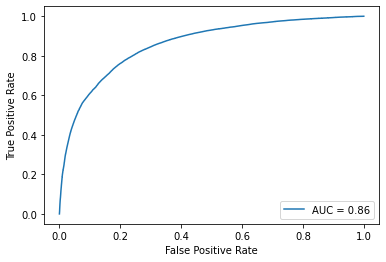

In [343]:
RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc).plot()

## 预测提交

In [349]:
data_test.rename(columns=col_replace,inplace=True)

In [350]:
## 准备测试集
data_test.isna().sum()

target           101503
percentage            0
age                   0
30-59                 0
DebtRatio             0
MonthlyIncome     20103
open_loan             0
90-                   0
estate_loan           0
60-89                 0
Dependents         2626
dtype: int64

In [351]:
fill_len = data_test.Dependents.isna().sum()
data_test.loc[data_test.Dependents.isna(),'Dependents']=\
np.random.choice(data_train_bak.loc[data_train_bak.Dependents.notna(),'Dependents'],fill_len,False)

In [352]:
fill_len = data_test.MonthlyIncome.isna().sum()
data_test.loc[data_test.MonthlyIncome.isna(),'MonthlyIncome']=\
np.random.choice(data_train_bak.loc[data_train_bak.MonthlyIncome.notna(),'MonthlyIncome'],fill_len,False)

In [355]:
data_test = woe_swag(data_test)

In [324]:
data_test.head()

,percentage,age,30-59,DebtRatio,MonthlyIncome,open_loan,90-,estate_loan,60-89,Dependents,target
0,1.198760,0.328633,-0.539718,-0.070896,-0.088885,-0.037839,-0.387441,0.249519,-0.285138,-0.148050,NaN
1,0.144396,-0.095919,-0.539718,0.292684,-0.287865,0.035548,-0.387441,0.396384,-0.285138,0.198229,NaN
2,-1.587446,-0.364289,-0.539718,0.379035,0.112459,-0.149013,-0.387441,-0.257524,-0.285138,0.198229,NaN
3,-0.354265,0.328633,0.891163,0.617674,0.336083,-0.195251,-0.387441,-0.199473,-0.285138,-0.148050,NaN
4,1.198760,0.555701,-0.539718,-0.120613,0.112459,-0.037839,-0.387441,0.249519,-0.285138,0.091527,NaN


In [ ]:
X_test = ss.transform(data_test.iloc[:,:-1].values)

In [ ]:
to_submit = lr.predict_proba(data_test.iloc[:,:-1].values)